In [18]:
import openseespy.opensees as ops
import numpy as np
import math
import pandas as pd
import os
import matplotlib.pyplot as plt

import idealisasi as IP

# Input dan output

In [19]:
folder_pushover = "D:/Belajar Open sees/Model 3D/Uploud Response Spectrum/DEMO/1. Capacity_PO_CentreQuality.csv"              # Folder path of pushover data         (Column 1 'Dt' in m  and column 2 'Vb' in kN)
folder_GMR = "D:/Belajar Open sees/Model 3D/Uploud Response Spectrum/DEMO/Data Gempa"                                         # Input Ground Motion file             (Column 1 constant time step in s and column 2 acceleration in g)
export_folder = 'D:/Belajar Open sees/Model 3D/Uploud Response Spectrum/DEMO/Export'                                          # Folder output

# Input Pushover Data

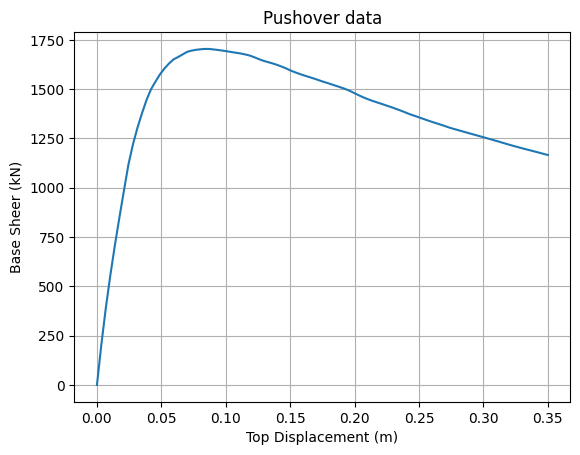

In [20]:
data_pushover = pd.read_csv(folder_pushover)

plt.plot(data_pushover.iloc[:, 0], data_pushover.iloc[:, 1])
plt.title('Pushover data')
plt.ylabel('Base Sheer (kN)')
plt.xlabel('Top Displacement (m)')
plt.grid(True)
plt.show()

# Pushover data idealization

d:\Belajar Open sees\Model 3D\Uploud Response Spectrum\idealisasi.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  max = [max[0],max[1]]


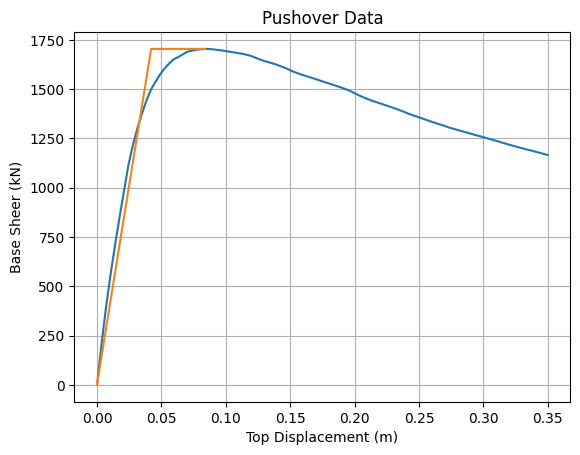

[0.042090000000002216, 1704.35]
[0.084, 1704.35]


In [21]:
point1, point2, point3 = IP.EPP(data_pushover, 0.001)                                                        # Idealizing pushover data in to bilinear with strain hardening and split into 3 damage state

fy = point2
fu = point3

strain_y = fy[0]
stress_y = fy[1]
strain_u = fu[0]
stress_u = fu[1]

Epp = np.array([point1, point2, point3])
plt.plot(data_pushover.iloc[:, 0], data_pushover.iloc[:, 1])
plt.plot(Epp[:, 0], Epp[:, 1])
plt.title('Pushover Data')
plt.ylabel('Base Sheer (kN)')
plt.xlabel('Top Displacement (m)')
plt.grid(True)
plt.show()

print(point2)
print(point3)

# Input Ground Motion folder

In [22]:
list_data = os.listdir(folder_GMR)
print(list_data)


['Big Bear-01 1992.csv', 'Borrego 1942.csv', 'Borrego-MTN 1968.csv', 'Coalingan-01 1983.csv', 'elCentro.csv', 'Kern County 1952.csv', 'Kobe Japan 1995.csv', 'Kocaeli Turkey 1999.csv', 'Lander 1992.csv', 'Morgan HIll 1984.csv', 'Northridge 1994.csv', 'Noto EW 2024.csv', 'Noto NS 2024.csv', 'Taiwan SMART1(45) 1986.csv', 'Tohoku EW 2011.csv', 'Tohoku NS 2011.csv']


In [23]:
sdv_point = []                                                                                                  # Define nececeray variable for analysis and store the result
pga_point = []

g = 9.81                                                                                                        # gravity
L = 1.0
d = 1
A = 1
I3= (1/12)
xDamp = 0.05                                                                                                    # damping default =  5%

# Response Spectrum Analysis + IDA
note :  The analysis normalize each grpund motion pga to 1 g,
        GMRS data scaling can be change on scale 

In [24]:
for record in list_data:
    GMRS = pd.read_csv(folder_GMR+"/"+record,header=None)
    dt = abs(GMRS.iloc[1, 0]-GMRS.iloc[0, 0])
    nPts = len(GMRS)
    GMRS_accl = GMRS.iloc[:, 1]
    Periode = []
    Accl = []
    Vel = []
    Disp = []
    
    #Response Spectrum
    for Period in np.arange(0.01, 10.0, 0.01):

        # model
        ops.wipe()

        ops.model('Basic', '-ndm', 2, '-ndf', 3)

        K = stress_y/strain_y
        E = K*L*L*L/I3

        M = K*(Period**2)/4/(np.pi**2)
        omega = np.sqrt(K/M)

        ops.node(1, 0, 0)
        ops.node(2, 0, 0)
        ops.node(3, 0, L)

        ops.mass(3, M, M, 0)

        ops.fix(1, 1, 1, 1)

        ops.equalDOF(1, 2, *[1, 2])

        ops.geomTransf('Linear', 1, 0, 1)

        ops.uniaxialMaterial('MultiLinear', 1, strain_y, stress_y, strain_u, stress_u)

        ops.element('zeroLength', 1, 1, 2, '-mat', 1, '-dir', 6, '-doRayleigh', 1) 

        ops.element('elasticBeamColumn', 2, 2, 3, A, E, I3, 1)

        # Set time series to be passed to uniform excitation
        ops.timeSeries('Path', 2,  '-values', *GMRS_accl, '-dt', dt, '-factor', g, 'prependZero')

        ops.pattern('UniformExcitation',  1,   1,  '-accel', 2, '-fact', 1)

        betaKcomm 	= 2.0*xDamp/omega; 	 
                    
        ops.rayleigh(0.0, 0.0, 0.0, betaKcomm)

        ops.wipeAnalysis()	
        ops.system('BandSPD')
        ops.constraints('Plain')
        ops.test('NormDispIncr', 1.0e-12,  100, 0) 
        ops.algorithm('Newton')  
        ops.numberer("RCM")                     
        ops.integrator('Newmark',  0.5,  0.25 )            
        ops.analysis("Transient")
        dtAnalysis    = dt
        TmaxAnanlysis = dt*nPts
        tFinal        = TmaxAnanlysis
        tCurrent      = ops.getTime()
        ok            = 0
        
        # Initializations of response
        u1            = []

        while ok == 0 and tCurrent < tFinal:
            ok = ops.analyze(1, dtAnalysis)
            # if the analysis fails try initial tangent iteration
            if ok != 0:
                print("Iteration failed .. lets try an initial stiffness for this step")
                ops.test('NormDispIncr', 1.0e-12,  100, 0)
                ops.algorithm('ModifiedNewton', '-initial')
                ok = ops.analyze( 1, .001)
                
                if ok == 0:
                    print("that worked .. back to regular newton")
                    ops.test('NormDispIncr', 1.0e-12,  10 )
                    ops.algorithm('Newton')    
            tCurrent = ops.getTime()
            u1.append(ops.nodeDisp(3, 1))

        max_disp = max(abs(x) for x in u1)
        Periode.append(Period)
        Accl.append(max_disp*(omega*omega)/g)
        Vel.append(max_disp*(omega))
        Disp.append(max_disp)

    rs = {
        'Periode (s)': Periode,
        'Sd (m)': Disp,
        'Sv (m/s)': Vel,
        'Sa (g)': Accl}
    rs = pd.DataFrame(rs)
    
    rs.to_csv(str(export_folder+'/'+record), index = None)
